# Task 3
---

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
# For modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
sns.set_palette('viridis')
pd.options.mode.chained_assignment = None  # Supress warning, default='warn'

ImportError: cannot import name 'DecisionBoundaryDisplay' from 'sklearn.inspection' (C:\anaconda3\envs\dataScience\lib\site-packages\sklearn\inspection\__init__.py)

# Read Data
In this section we read the data in after the preprocessing from the preprocessing notebook

In [12]:
df = pd.read_pickle('../data/preprocessed/accepted_df_preprocessed.pkl')
print(f"Shape of df: {df.shape}")
df.head(5)

Shape of df: (1345310, 94)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,3600.0,3600.0,3600.0,36,13.99,123.03,C,C4,10.0,MORTGAGE,...,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0
1,24700.0,24700.0,24700.0,36,11.99,820.28,C,C1,10.0,MORTGAGE,...,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0
2,20000.0,20000.0,20000.0,60,10.78,432.66,B,B4,10.0,MORTGAGE,...,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0
4,10400.0,10400.0,10400.0,60,22.45,289.91,F,F1,3.0,MORTGAGE,...,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0
5,11950.0,11950.0,11950.0,36,13.44,405.18,C,C3,4.0,RENT,...,0.0,0.0,100.0,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0


# Encode Features from categorical to numerical

In [13]:
# Preview categorical data
print(df.dtypes.value_counts())
# Get categorical columns names
cat_columns = df.select_dtypes(include=['object']).columns.tolist()
# change format
for col in cat_columns:
    df[col] = df[col].astype('category')

float64    87
object      6
int32       1
dtype: int64


In [14]:
# Label Encoding
df_ec = df.copy()
for col in cat_columns:
    df_ec[col] = df[col].cat.codes
# check
df_ec.dtypes.value_counts()

float64    87
int8        6
int32       1
dtype: int64

In [15]:
# One-Hot-Encoding
df_hoe = pd.get_dummies(data=df, columns=cat_columns, drop_first=True)
# check
df_hoe.dtypes.value_counts()

float64    87
uint8      49
int32       1
dtype: int64

In [16]:
# Binary Encoding
import category_encoders as ce
encoder = ce.BinaryEncoder(cols=cat_columns)
df_binary = encoder.fit_transform(df)
# check
df_binary.dtypes.value_counts()

C:\anaconda3\envs\dataScience\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical_dtype(cols):


float64    87
int64      22
int32       1
dtype: int64

In [17]:
# Convert all values to float
df_ec = df_ec.astype(float)
df_binary = df_binary.astype(float)
df_hoe = df_hoe.astype(float)

0.0    1076751
1.0     268559
Name: loan_status, dtype: int64
(1345310, 110)


<AxesSubplot:ylabel='Type'>

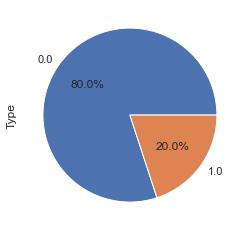

In [39]:
print(df_binary.loan_status.value_counts())
print(df_binary.shape)
df_binary.groupby('loan_status').size().plot(kind='pie', y = "loan_status", label = "Type", autopct='%1.1f%%')

In [36]:
# Take only fraction of the data
df_binary_sample = df_binary.sample(frac = 0.4)
print(df_binary_sample.shape)
print(df_binary_sample.loan_status.value_counts())

(538124, 110)
0.0    430281
1.0    107843
Name: loan_status, dtype: int64


0.0    140196
1.0    107843
Name: loan_status, dtype: int64


<AxesSubplot:ylabel='Type'>

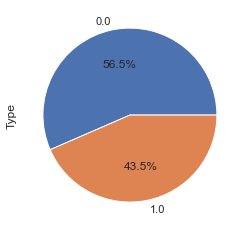

In [38]:
# Downsampling
loan_status_0 = df_binary_sample[df_binary_sample["loan_status"] == 0.0]
loan_status_1  = df_binary_sample[df_binary_sample["loan_status"] == 1.0]

loan_status_0_downsample = resample(loan_status_0,
             replace=True,
             n_samples=round(1.3*len(loan_status_1)),
             random_state=42)

df_binary_downsampled = pd.concat([loan_status_0_downsample, loan_status_1])

print(df_binary_downsampled["loan_status"].value_counts())
df_binary_downsampled.groupby('loan_status').size().plot(kind='pie', y = "loan_status", label = "Type", autopct='%1.1f%%')

In [40]:
# Fill NaNs with Median
df_binary_downsampled = df_binary_downsampled.fillna(df_binary_downsampled.median())
# Preview
df_binary_downsampled.head(5)

,loan_amnt,funded_amnt,funded_amnt_inv,term_0,term_1,int_rate,installment,grade_0,grade_1,grade_2,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
1757334,15000.0,15000.0,15000.0,1.0,0.0,12.85,340.15,0.0,0.0,1.0,...,0.0,1.0,100.0,12.5,0.0,0.0,311063.0,275900.0,40200.0,254863.0
1874760,4000.0,4000.0,4000.0,0.0,1.0,15.80,140.24,0.0,0.0,0.0,...,0.0,3.0,92.0,100.0,0.0,0.0,129966.0,28616.0,5200.0,25366.0
1191841,7000.0,7000.0,7000.0,0.0,1.0,11.67,231.40,0.0,0.0,1.0,...,0.0,1.0,96.2,0.0,0.0,0.0,119389.0,21336.0,29400.0,14853.0
953840,10100.0,10100.0,10100.0,1.0,0.0,29.99,326.71,0.0,0.0,1.0,...,0.0,4.0,100.0,0.0,0.0,0.0,78300.0,39927.0,48700.0,25000.0
535780,3000.0,3000.0,3000.0,0.0,1.0,13.59,101.94,0.0,0.0,0.0,...,0.0,0.0,100.0,50.0,0.0,0.0,6200.0,6209.0,0.0,0.0


# Remove Highly Correlated Features
Keeping highly correlated features do not add much more information to our model but making it more complex. Thus we remove highly correlated features that exceed a certain threshold.

In [43]:
corr = df.corr()
corr["loan_status"].sort_values()

last_fico_range_high   -0.667289
last_fico_range_low    -0.576656
total_rec_prncp        -0.435683
last_pymnt_amnt        -0.346609
total_pymnt            -0.311751
                          ...   
recoveries              0.509232
loan_status             1.000000
out_prncp                    NaN
out_prncp_inv                NaN
policy_code                  NaN
Name: loan_status, Length: 100, dtype: float64

## Data Split
In this section we split the data into a training and test set. The corresponding model is then trained on the training set and tested on the test set.

In [12]:
# Fraction of test data
TEST_SIZE = 0.3

X = df_binary_downsampled.drop("loan_status", axis=1)
y = df_binary_downsampled["loan_status"]

# Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42, stratify=y)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (173627, 109)
Shape of X_test: (74412, 109)
Shape of y_train: (173627,)
Shape of y_test: (74412,)


In [13]:
# Init object
scaler = StandardScaler()
# Scale X_train
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.head(5)

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
0,0.183492,0.184738,0.187299,-0.564617,-1.440283,0.199948,1.120904,-0.418802,0.005532,-0.363192,...,-0.006517,-0.010305,2.866861,-0.808439,-0.794039,-0.672927,0.845174,-0.136277,-0.072987,-0.161162
1,0.000283,0.001443,0.004064,1.771112,1.733437,-0.166789,-0.836298,-0.178485,0.053726,-0.363192,...,-0.006517,-0.010305,-0.348814,-0.808439,-0.794039,1.486046,0.845174,-0.136277,-0.072987,-0.161162
2,-0.088458,-0.087341,-0.084690,1.771112,2.258888,-0.173128,0.282103,-0.771267,1.111623,-0.363192,...,-0.006517,-0.010305,-0.348814,1.236952,-0.794039,1.486046,0.845174,-0.136277,-0.072987,-0.161162
3,-0.732550,-0.731738,-0.728873,-0.564617,-0.235951,-0.653164,-1.115898,-0.819331,0.063997,-0.363192,...,-0.006517,-0.010305,-0.348814,1.236952,1.259385,-0.672927,-1.183188,-0.136277,-0.072987,-0.161162
4,-0.503540,-0.502619,-0.499830,-0.564617,-1.019923,-0.466091,-1.115898,-0.659119,-0.583066,4.234800,...,-0.006517,-0.010305,-0.348814,-0.808439,1.259385,-0.672927,-1.183188,-0.136277,-0.072987,-0.161162


# Fit Model

In [ ]:
# Predict in-sample values
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)
y_pred = lr.predict(X_test_scaled)

## Test Model

In [68]:
# Plot Confusion matrics
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot classification report
print(80 * "_")
print(classification_report(y_true=y_test, y_pred=y_pred))
print("Information:")
print("Precision: Percentage of correct positive predictions relative to total positive predictions")
print("Recall: Percentage of correct positive predictions relative to total actual positives.")
print("F1 Score: A weighted harmonic mean of precision and recall. The closer to 1, the better the model.")
print(80 * "_")

# Task 4
---

Comparing
* logistic regression,
* classification tree,
* random forest,
* bagging,
* support vector machine (with two kernel functions),
* and neural network
for default prediction based on the out-of-sample performance measures (at least three different measures).

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [ ]:
%%time
models = []

models.append(("LogisticRegression",LogisticRegression(fit_intercept=True, max_iter=10000, solver="saga")))
models.append(("DecisionTree",DecisionTreeClassifier()))
models.append(("RandomForest",RandomForestClassifier()))
models.append(("BaggingCLF",BaggingClassifier()))
models.append(("SVC",SVC(kernel='rbf')))
models.append(("SVC",SVC(kernel="linear")))
models.append(("NeuronalNetwork", MLPClassifier(alpha=1, max_iter=1000)))

results = []
names = []
for name,model in tqdm(models):
    result = cross_val_score(model, X_train_scaled, y_train,  cv=3)
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

In [ ]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
# data point plot - total, train, test
figure, ax = plt.subplot(3, len(models))

cm_bright = ListedColormap(["#FF0000", "#0000FF"])
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

for ax, model in zip(ax.flatten(), models):
    
    name = model[0]
    clf = model[1]
    
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    DecisionBoundaryDisplay.from_estimator(
        clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
    )

    # Plot the training points
    ax.scatter(
        X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
    )
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test,
        cmap=cm_bright,
        edgecolors="k",
        alpha=0.6,
    )

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(f"{name}")
    ax.text(
        x_max - 0.3,
        y_min + 0.3,
        ("%.2f" % score).lstrip("0"),
        size=15,
        horizontalalignment="right",
    )

plt.tight_layout()
plt.show()